Code from https://www.tensorflow.org/tutorials/audio/simple_audio    
TPU Example https://www.kaggle.com/mgornergoogle/five-flowers-with-keras-and-xception-on-tpu#TPU-or-GPU-detection  
Log Mel Spectrogram: https://towardsdatascience.com/how-to-easily-process-audio-on-your-gpu-with-tensorflow-2d9d91360f06

In [1]:
import os
import pathlib
import time
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Tensorflow version 2.4.1


In [2]:
try: # detect TPUs
    # NEW: in Tensorflow 2.4
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() 
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # otherwise detect GPUs
    strategy = tf.distribute.MirroredStrategy() # single-GPU or multi-GPU


print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: grpc://10.49.88.250:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.49.88.250:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of accelerators:  8


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import auth
auth.authenticate_user()
project_id = 'colab-tpu-310620'
!gcloud config set project {project_id}

Updated property [core/project].


In [47]:
bucket_name = 'sys6018_audio'
# !gsutil -m cp -r /content/drive/MyDrive/Repositories/Audio-Language-Detection/Data/ gs://{bucket_name}/segments
!gsutil -m cp -r gs://{bucket_name}/models /content/drive/MyDrive/Repositories/Audio-Language-Detection/ 

Copying gs://sys6018_audio/models/model1/variables/variables.index...
Copying gs://sys6018_audio/models/model1/saved_model.pb...
Copying gs://sys6018_audio/models/model1_norm/variables/variables.data-00000-of-00001...
Copying gs://sys6018_audio/models/model1_norm/saved_model.pb...
Copying gs://sys6018_audio/models/model1/variables/variables.data-00000-of-00001...
Copying gs://sys6018_audio/models/model2/saved_model.pb...
Copying gs://sys6018_audio/models/model1_norm/variables/variables.index...
Copying gs://sys6018_audio/models/model2/variables/variables.data-00000-of-00001...
Copying gs://sys6018_audio/models/model2/variables/variables.index...
Copying gs://sys6018_audio/models/model3/saved_model.pb...
Copying gs://sys6018_audio/models/model3/variables/variables.data-00000-of-00001...
Copying gs://sys6018_audio/models/model3/variables/variables.index...
Copying gs://sys6018_audio/models/model3_4_languages/saved_model.pb...
Copying gs://sys6018_audio/models/model3_4_languages/variables

In [5]:
# languages = ['en', 'it']
# path = '../Data'
# path = '/scratch/na5zn/Audio-Language-Detection/Data/segments'
# path = '/content/drive/MyDrive/Repositories/Audio-Language-Detection/Data/segments'
path = 'gs://sys6018_audio/segments'

In [6]:
commands = np.array(tf.io.gfile.listdir(path))
commands = list(map(lambda x: x.replace('/', ''), commands))
print('Languages:', commands)

num_labels = len(commands)

Languages: ['de', 'en', 'it', 'sp']


In [7]:
filenames = !gsutil ls -r gs://sys6018_audio/segments/*/*.wav
# filenames = tf.io.gfile.glob(str(data_dir) + '/*/*.wav')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(path + '/' + commands[0] + '/')))
print('Example file tensor:', filenames[0])

Number of total examples: 53473
Number of examples per label: 17940
Example file tensor: tf.Tensor(b'gs://sys6018_audio/segments/it/divina_commedia_07_alighieri_64kb_323.wav', shape=(), dtype=string)


In [8]:
# num_samples = 20

train_size = int(0.7*num_samples)
val_size = int(0.15*num_samples)
test_size = num_samples - train_size - val_size

train_files = filenames[:train_size]
val_files = filenames[train_size: train_size + val_size]
test_files = filenames[train_size + val_size:train_size + val_size + test_size]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 37431
Validation set size 8020
Test set size 8022


In [9]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

In [10]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)

    # Note: You'll use indexing here instead of tuple unpacking to enable this 
    # to work in a TensorFlow graph.
    return parts[-2]

In [11]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [12]:
def get_spectrogram(waveform):
    # Padding for files with less than 16000 samples
    print(tf.shape(waveform))
    zero_padding = tf.zeros([66150] - tf.shape(waveform), dtype=tf.float32)

    # Concatenate audio with padding so that all audio clips will be of the 
    # same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

    spectrogram = tf.abs(spectrogram)

    return spectrogram

In [13]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

In [14]:
input_shape = [515, 129, 1]

def reshape(audio, label):
  return (tf.reshape(audio, input_shape), label)

def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
        get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
    # Reshape explicitly for TPU to work
    for spectrogram, _ in output_ds.take(1):
      global input_shape
      input_shape = spectrogram.shape
      print(input_shape)
    output_ds = output_ds.map(reshape, num_parallel_calls=AUTOTUNE)
    return output_ds

In [15]:
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
TRAIN_STEPS = train_files.shape[0] // BATCH_SIZE
VALIDATION_STEPS = -(-val_files.shape[0] // BATCH_SIZE)

Learning rate schedule: 0.0001 to 0.0004 to 1e-05


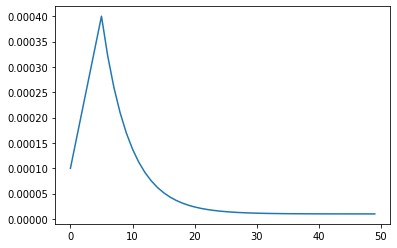

In [33]:
# Learning rate schedule

EPOCHS = 50

LR_START = 0.00010
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [17]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Tensor("Shape:0", shape=(1,), dtype=int32)
(515, 129, 1)
Tensor("Shape:0", shape=(1,), dtype=int32)
(515, 129, 1)
Tensor("Shape:0", shape=(1,), dtype=int32)
(515, 129, 1)


In [18]:
unbatched_train_ds = train_ds
train_ds = train_ds.prefetch(AUTOTUNE).batch(BATCH_SIZE).cache().repeat()
val_ds = val_ds.prefetch(AUTOTUNE).batch(BATCH_SIZE).cache().repeat()

In [19]:
input_shape

TensorShape([515, 129, 1])

In [34]:
keras.backend.clear_session()

with strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  # norm_layer = preprocessing.Normalization()
  # norm_layer.adapt(unbatched_train_ds.map(lambda x, _: x))

  model = models.Sequential([
      layers.Input(shape=input_shape),
      # preprocessing.Resizing(32, 32), 
      # norm_layer,
      # model3
      layers.Conv2D(32, (3, 3), padding='same',
                 input_shape=input_shape),
      layers.Activation('relu'),
      layers.Conv2D(64, (3, 3)),
      layers.Activation('relu'),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Dropout(0.25),
      layers.Conv2D(64, (3, 3), padding='same'),
      layers.Activation('relu'),
      layers.Conv2D(64, (3, 3)),
      layers.Activation('relu'),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Dropout(0.5),
      layers.Conv2D(128, (3, 3), padding='same'),
      layers.Activation('relu'),
      layers.Conv2D(128, (3, 3)),
      layers.Activation('relu'),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Dropout(0.5),
      layers.Flatten(),
      layers.Dense(512),
      layers.Activation('relu'),
      layers.Dropout(0.5),
      layers.Dense(num_labels, activation='softmax')

      # model2
      # layers.Conv2D(32, 3, activation='relu'),
      # layers.MaxPooling2D(),
      # layers.Conv2D(64, 3, activation='relu'),
      # layers.Conv2D(128, 3, activation='relu'),
      # layers.MaxPooling2D(),
      # layers.Flatten(),
      # layers.Dense(128, activation='relu'),
      # layers.Dropout(0.5),
      # layers.Dense(num_labels, activation='softmax'),

      # model1
      # layers.Conv2D(32, 16, activation='relu'),
      # layers.MaxPooling2D(),
      # layers.Flatten(),
      # layers.Dense(num_labels, activation='softmax'),
  ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 515, 129, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 515, 129, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 513, 127, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 513, 127, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 63, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 256, 63, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 63, 64)       3

In [35]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(lr=0.0001, epsilon=0.1),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'],
  steps_per_execution=8
)

In [36]:
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    steps_per_epoch=TRAIN_STEPS, 
    validation_steps=VALIDATION_STEPS,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=5)]
    # callbacks=[lr_callback, tf.keras.callbacks.EarlyStopping(verbose=1, patience=5)]
)

Epoch 1/50
584/584 [==============================] - 50s 86ms/step - loss: 1.3703 - accuracy: 0.2750 - val_loss: 1.3184 - val_accuracy: 0.3444
Epoch 2/50
584/584 [==============================] - 40s 68ms/step - loss: 1.2943 - accuracy: 0.3555 - val_loss: 1.2943 - val_accuracy: 0.3741
Epoch 3/50
584/584 [==============================] - 34s 59ms/step - loss: 1.2576 - accuracy: 0.4029 - val_loss: 1.2430 - val_accuracy: 0.4296
Epoch 4/50
584/584 [==============================] - 34s 59ms/step - loss: 1.2002 - accuracy: 0.4289 - val_loss: 1.1771 - val_accuracy: 0.4522
Epoch 5/50
584/584 [==============================] - 35s 59ms/step - loss: 1.1525 - accuracy: 0.4477 - val_loss: 1.1440 - val_accuracy: 0.4675
Epoch 6/50
584/584 [==============================] - 34s 59ms/step - loss: 1.1273 - accuracy: 0.4641 - val_loss: 1.1186 - val_accuracy: 0.4879
Epoch 7/50
584/584 [==============================] - 34s 59ms/step - loss: 1.1063 - accuracy: 0.4745 - val_loss: 1.0978 - val_accuracy:

In [48]:
save_path = 'gs://sys6018_audio/models/model3_4_languages_50_epochs'
model.save(save_path, save_format='tf')

INFO:tensorflow:Assets written to: gs://sys6018_audio/models/model3_4_languages_50_epochs/assets


INFO:tensorflow:Assets written to: gs://sys6018_audio/models/model3_4_languages_50_epochs/assets


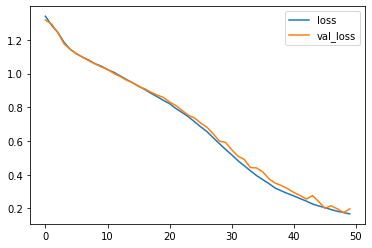

In [38]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [39]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [40]:
# saved_model = tf.keras.models.load_model('gs://sys6018_audio/models/model3')
start_time = time.time()
y_pred = np.argmax(model.predict(test_audio), axis=1)
end_time = time.time()
speed = (end_time - start_time) / len(test_labels) * 1000
print(f'Inference time: {speed:.1f} seconds per 1000 samples')

y_true = test_labels
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.1%}')

Inference time: 5.2 seconds per 1000 samples
Test set accuracy: 93.7%


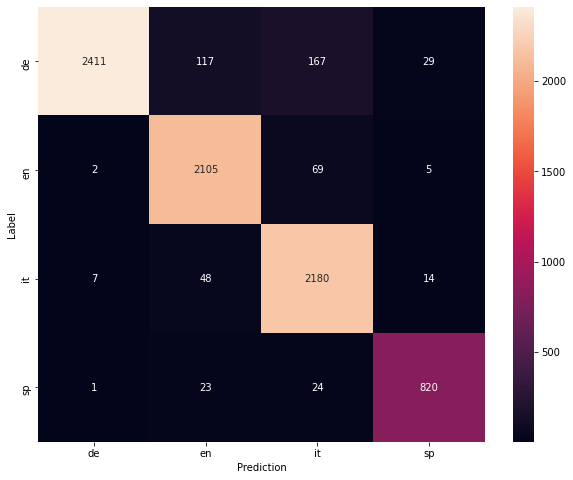

In [41]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

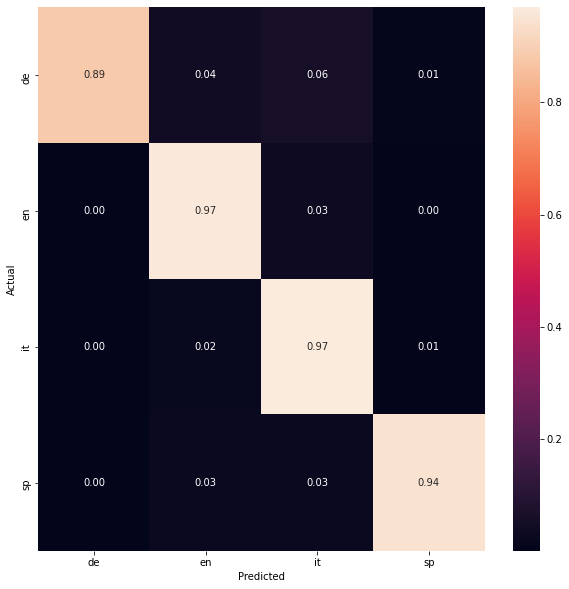

In [46]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=commands, yticklabels=commands)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Get accuracy for clips grouped together
So theoretically, a 30 second clip of audio will be 100% accurate if broken into 3 second clips and taking the mode of predictions for each clip in the group.

In [53]:
import pandas as pd
df = pd.DataFrame({"label": y_true, "prediction": y_pred})

In [72]:
for l in sorted(df['label'].unique()):
  df_sub = df[df['label'] == l]
  df_agg = df_sub.groupby(np.arange(len(df_sub)) // 10).agg(lambda x: x.mode().to_numpy()[-1])
  a = len(df_agg[df_agg['label'] == df_agg['prediction']])/len(df_agg)
  print(f'Label: {l}, Accuracy: {a}')

Label: 0, Accuracy: 1.0
Label: 1, Accuracy: 1.0
Label: 2, Accuracy: 1.0
Label: 3, Accuracy: 1.0


## Get accuracy on test clip
These clips were recorded by Nikki

In [74]:
test_path = 'gs://sys6018_audio/Test_Data/segments'

In [75]:
commands = np.array(tf.io.gfile.listdir(test_path))
commands = list(map(lambda x: x.replace('/', ''), commands))
print('Languages:', commands)

num_labels = len(commands)

Languages: ['en', 'sp']


In [76]:
filenames = !gsutil ls -r gs://sys6018_audio/Test_Data/segments/*/*.wav
# filenames = tf.io.gfile.glob(str(data_dir) + '/*/*.wav')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(path + '/' + commands[0] + '/')))
print('Example file tensor:', filenames[0])

Number of total examples: 37
Number of examples per label: 14882
Example file tensor: tf.Tensor(b'gs://sys6018_audio/Test_Data/segments/en/test_en_21.wav', shape=(), dtype=string)


In [77]:
test_ds = preprocess_dataset(filenames)

Tensor("Shape:0", shape=(1,), dtype=int32)
(515, 129, 1)


In [78]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)


In [88]:
# transform labels to match original dataset from training
# label_key = {'de':0, 'en':1, 'it':2, 'sp':3}
# test_label_key = {'en': 0, 'sp': 1}

test_labels = np.where(test_labels == 1, 3, test_labels)
test_labels = np.where(test_labels == 0, 1, test_labels)

In [89]:
# saved_model = tf.keras.models.load_model('gs://sys6018_audio/models/model3')
start_time = time.time()
y_pred = np.argmax(model.predict(test_audio), axis=1)
end_time = time.time()
speed = (end_time - start_time) / len(test_labels) * 1000
print(f'Inference time: {speed:.1f} seconds per 1000 samples')

y_true = test_labels
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.1%}')

Inference time: 17.4 seconds per 1000 samples
Test set accuracy: 59.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


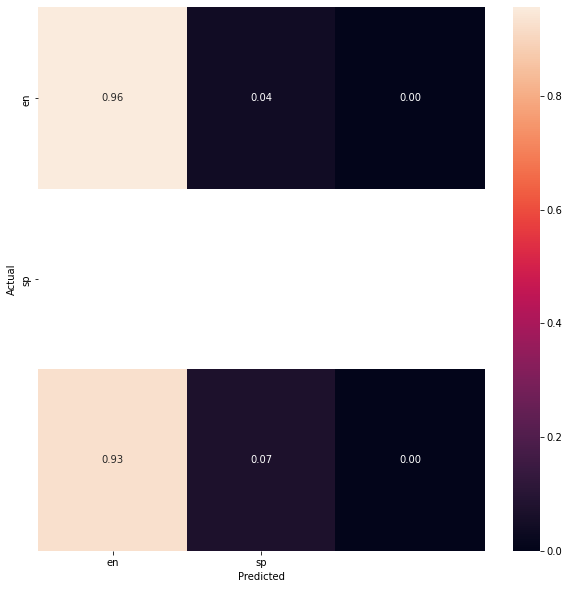

In [90]:
cm = confusion_matrix(y_true, y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=commands, yticklabels=commands)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [85]:
y_pred

array([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [86]:
y_true

array([1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 3, 1,
       1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1])

## Get predictions from Google Cloud AI

In [ ]:
! pip install google-api-python-client

In [ ]:
! pip install --upgrade google-api-python-client oauth2client

     |████████████████████████████████| 7.0MB 6.4MB/s 
Requirement already up-to-date: oauth2client in /usr/local/lib/python3.7/dist-packages (4.1.3)
ERROR: earthengine-api 0.1.260 has requirement google-api-python-client<2,>=1.12.1, but you'll have google-api-python-client 2.2.0 which is incompatible.
  Found existing installation: google-auth-httplib2 0.0.4
    Uninstalling google-auth-httplib2-0.0.4:
      Successfully uninstalled google-auth-httplib2-0.0.4
  Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8


In [ ]:
import googleapiclient.discovery
from google.api_core.client_options import ClientOptions

# the service account private key!
# you don't want to paste this into a public notebook...
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = '/content/vaulted-bivouac-311919-46d68238fb31.json'

# https://cloud.google.com/ai-platform/prediction/docs/regional-endpoints
endpoint = 'https://us-east4-ml.googleapis.com'
client_options = ClientOptions(api_endpoint=endpoint)
# region could matter 
# Under NaviMenu > AI Platform > Models
# my "Endpoint" is us-east4-ml

# this finds the model_path
ml_resource = googleapiclient.discovery.build("ml", "v1", client_options=client_options, cache_discovery=False).projects()
# https://stackoverflow.com/questions/40154672/importerror-file-cache-is-unavailable-when-using-python-client-for-google-ser
client_options

ClientOptions: {'api_endpoint': 'https://us-east4-ml.googleapis.com', 'client_cert_source': None, 'client_encrypted_cert_source': None, 'quota_project_id': None, 'credentials_file': None, 'scopes': None}

In [ ]:
import sys
instances = []
for i,j in test_ds.take(1):
    input_data = i.numpy().tolist()
    instances.append(input_data)

prediction_data = {"instances": instances}

4192


In [ ]:
print(sys.getsizeof(prediction_data))

248


In [ ]:
project_id = "vaulted-bivouac-311919" # change this to your project ID
model_id = "AudioClassificationTensorFlow" # named in GCP
model_ver = "model003" # named in GCP
model_path = "projects/{}/models/{}/versions/{}".format(project_id, model_id, model_ver)
print(model_path)

request = ml_resource.predict(name=model_path, body=prediction_data)
response = request.execute()  

In [ ]:
response

{'predictions': [[1.57841828e-14, 1.0]]}